In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sqlalchemy import create_engine
from datetime import datetime
import os
from dotenv import load_dotenv
import warnings
import requests

plt.style.use('ggplot')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas e configuradas com sucesso!")

API_URL = "http://127.0.0.1:8000/dataframe_pmdf"

response = requests.get(API_URL)

if response.status_code == 200:
    data = response.json()["data"]
    df = pd.DataFrame(data)  
    print("✅ Dados carregados com sucesso!")
else:
    print(f"❌ Erro ao buscar dados: {response.status_code} - {response.text}")

df.head()  


✅ Bibliotecas importadas e configuradas com sucesso!
✅ Dados carregados com sucesso!


,uf,municipio,evento,mês,ano,data_referencia,agente,arma,feminino,masculino,nao_informado,total_vitima,total,total_peso,Unnamed: 14,Unnamed: 15
0,DF,NÃO INFORMADO,Apreensão de Cocaína,1.0,2024.0,2024-01-01T00:00:00,None,None,NaN,NaN,NaN,NaN,NaN,28.000,None,None
1,DF,NÃO INFORMADO,Apreensão de Cocaína,2.0,2024.0,2024-02-01T00:00:00,None,None,NaN,NaN,NaN,NaN,NaN,45.000,None,None
2,DF,NÃO INFORMADO,Apreensão de Cocaína,3.0,2024.0,2024-03-01T00:00:00,None,None,NaN,NaN,NaN,NaN,NaN,16.000,None,None
3,DF,NÃO INFORMADO,Apreensão de Cocaína,4.0,2024.0,2024-04-01T00:00:00,None,None,NaN,NaN,NaN,NaN,NaN,104.395,None,None
4,DF,NÃO INFORMADO,Apreensão de Cocaína,5.0,2024.0,2024-05-01T00:00:00,None,None,NaN,NaN,NaN,NaN,NaN,11.000,None,None


Celula 2

In [8]:
# Função para conectar ao banco de dados
def conectar_banco():
    """Estabelece conexão com o banco de dados PostgreSQL na nuvem"""
    load_dotenv()  # Carrega variáveis do .env
    
    DB_USER = os.getenv("DB_USER")
    DB_PASSWORD = os.getenv("DB_PASSWORD")
    DB_HOST = os.getenv("DB_HOST")
    DB_NAME = os.getenv("DB_NAME")
    DB_SSL_MODE = os.getenv("DB_SSL_MODE", "require")
    
    DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}?sslmode={DB_SSL_MODE}"
    
    try:
        engine = create_engine(DATABASE_URL)
        print("✅ Conexão com o banco de dados estabelecida com sucesso!")
        return engine
    except Exception as e:
        print(f"❌ Falha na conexão: {str(e)}")
        return None

# Estabelece conexão
engine = conectar_banco()

✅ Conexão com o banco de dados estabelecida com sucesso!


Celular 3

In [9]:
# Função para carregar dados com otimização (versão corrigida)
def carregar_dados(engine):
    """Carrega dados do banco com otimizações para análise"""
    query = """
    SELECT 
        uf, municipio, evento, mês, ano, agente, arma,
        masculino, feminino, nao_informado, total_vitima, total, total_peso
    FROM dataframe_pmdf
    """
    
    try:
        # Carrega em chunks para evitar sobrecarga de memória
        chunks = pd.read_sql_query(query, engine, chunksize=10000)
        df = pd.concat(chunks, ignore_index=True)
        
        # Verifica os tipos de dados
        print("Tipos de dados antes da conversão:")
        print(df[['ano', 'mês']].dtypes)
        
        # Converte para inteiros primeiro
        df['ano'] = df['ano'].astype(int)
        df['mês'] = df['mês'].astype(int)
        
        # Pré-processamento eficiente - agora com formato correto
        df['data'] = pd.to_datetime(
            df['ano'].astype(str) + '-' + 
            df['mês'].astype(str).str.zfill(2) + '-01',
            format='%Y-%m-%d'
        )
        
        # Processamento adicional
        df['evento'] = df['evento'].str.replace(' EXCLUIR', '')
        df['regiao'] = df['municipio'].replace({
            'BRASÍLIA/PLANO PILOTO': 'PLANO PILOTO',
            'SOBRADINHO II': 'SOBRADINHO',
            'RIACHO FUNDO II': 'RIACHO FUNDO'
        })
        
        # Renomeia colunas para facilitar o uso no código
        df = df.rename(columns={'mês': 'mes'})
        
        print(f"\n📊 Dados carregados: {len(df)} registros")
        print("\nPrimeiras linhas do dataframe:")
        display(df.head(3))
        
        print("\nInformações do dataframe:")
        print(df.info())
        
        return df
    except Exception as e:
        print(f"❌ Erro ao carregar dados: {str(e)}")
        return None

# Carrega os dados
df = carregar_dados(engine)

Tipos de dados antes da conversão:
ano    float64
mês    float64
dtype: object

📊 Dados carregados: 13231 registros

Primeiras linhas do dataframe:


,uf,municipio,evento,mes,ano,agente,arma,masculino,feminino,nao_informado,total_vitima,total,total_peso,data,regiao
0,DF,NÃO INFORMADO,Apreensão de Cocaína,1,2024,None,None,NaN,NaN,NaN,NaN,NaN,28.0,2024-01-01,NÃO INFORMADO
1,DF,NÃO INFORMADO,Apreensão de Cocaína,2,2024,None,None,NaN,NaN,NaN,NaN,NaN,45.0,2024-02-01,NÃO INFORMADO
2,DF,NÃO INFORMADO,Apreensão de Cocaína,3,2024,None,None,NaN,NaN,NaN,NaN,NaN,16.0,2024-03-01,NÃO INFORMADO



Informações do dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13231 entries, 0 to 13230
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   uf             13231 non-null  object        
 1   municipio      13231 non-null  object        
 2   evento         13231 non-null  object        
 3   mes            13231 non-null  int64         
 4   ano            13231 non-null  int64         
 5   agente         648 non-null    object        
 6   arma           324 non-null    object        
 7   masculino      10053 non-null  float64       
 8   feminino       10019 non-null  float64       
 9   nao_informado  10002 non-null  float64       
 10  total_vitima   10062 non-null  float64       
 11  total          1359 non-null   float64       
 12  total_peso     72 non-null     float64       
 13  data           13231 non-null  datetime64[ns]
 14  regiao         13231 non-null  object      

Celula 4


ANÁLISE TEMPORAL


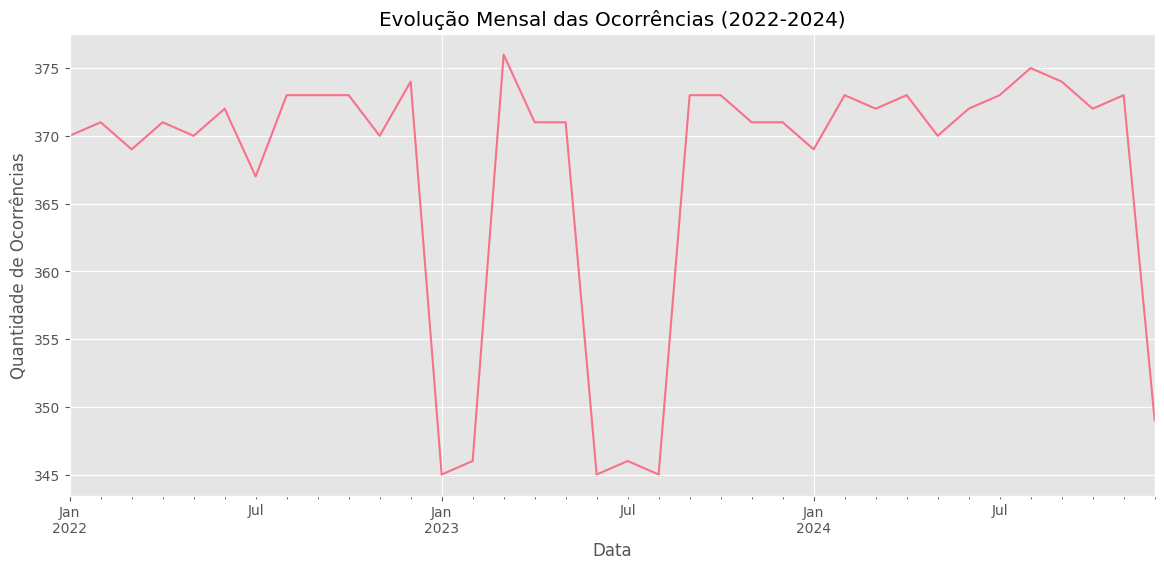

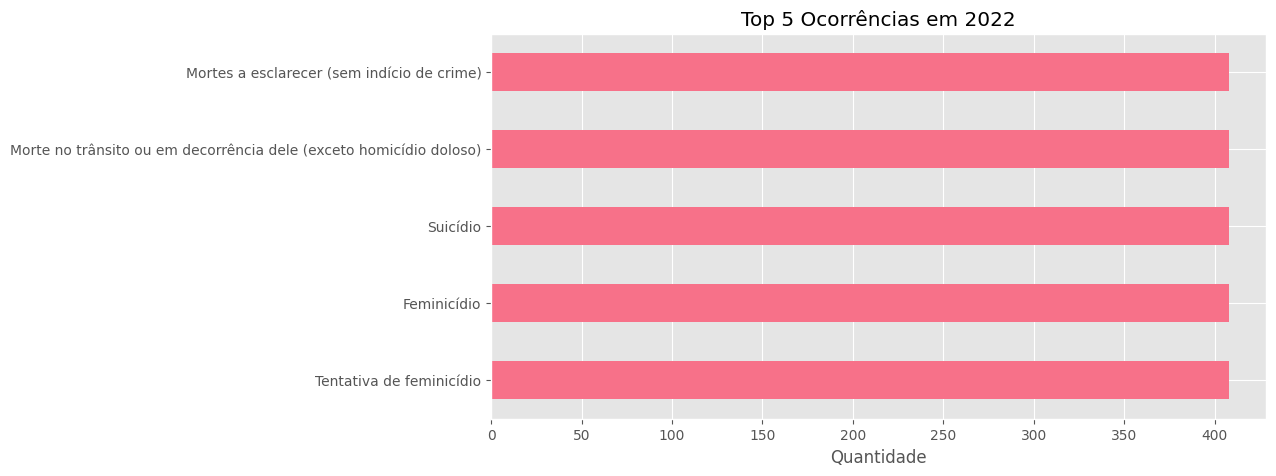

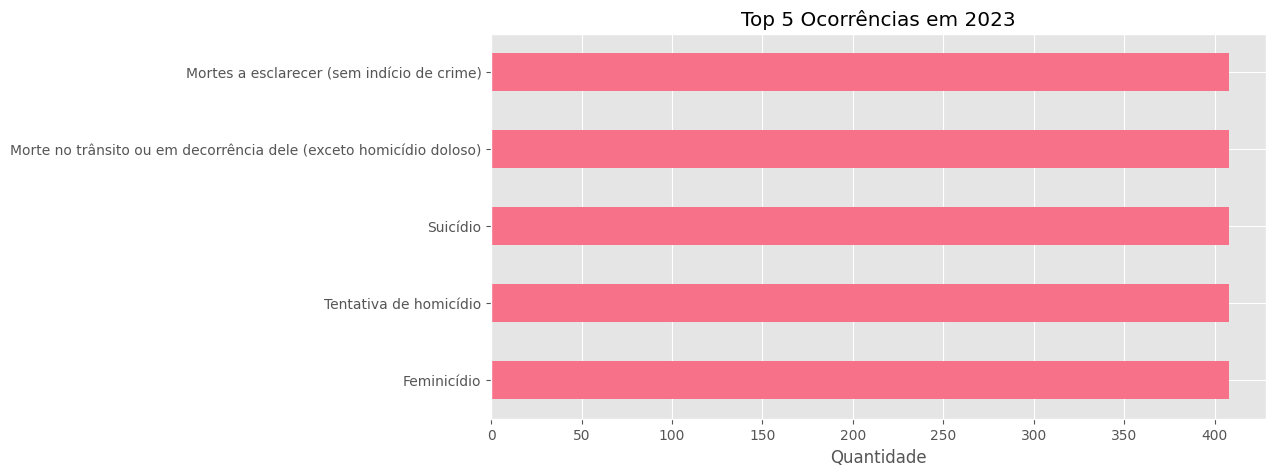

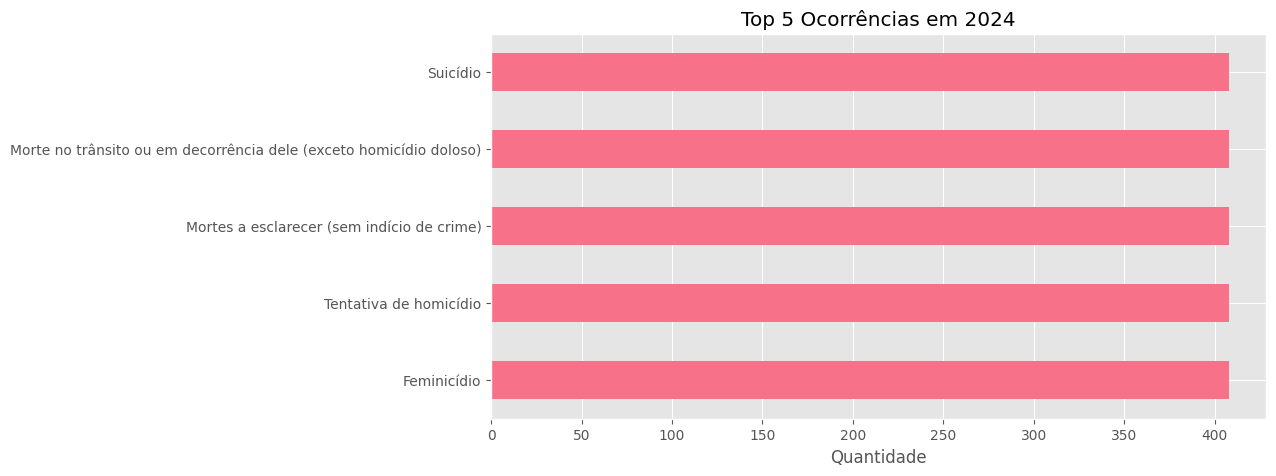

In [10]:
def analise_temporal(df):
    print("\nANÁLISE TEMPORAL")
    
    # Gráfico de evolução mensal
    plt.figure(figsize=(14, 6))
    df['data'].value_counts().sort_index().plot()
    plt.title('Evolução Mensal das Ocorrências (2022-2024)')
    plt.ylabel('Quantidade de Ocorrências')
    plt.xlabel('Data')
    plt.grid(True)
    plt.show()
    
    # Top eventos por ano
    for year in sorted(df['ano'].unique()):
        year_data = df[df['ano'] == year]
        top_events = year_data['evento'].value_counts().nlargest(5)
        
        plt.figure(figsize=(10, 5))
        top_events.plot(kind='barh')
        plt.title(f'Top 5 Ocorrências em {year}')
        plt.xlabel('Quantidade')
        plt.ylabel('')
        plt.show()

# Executa análise temporal
analise_temporal(df)

Celula 5


ANÁLISE GEOGRÁFICA


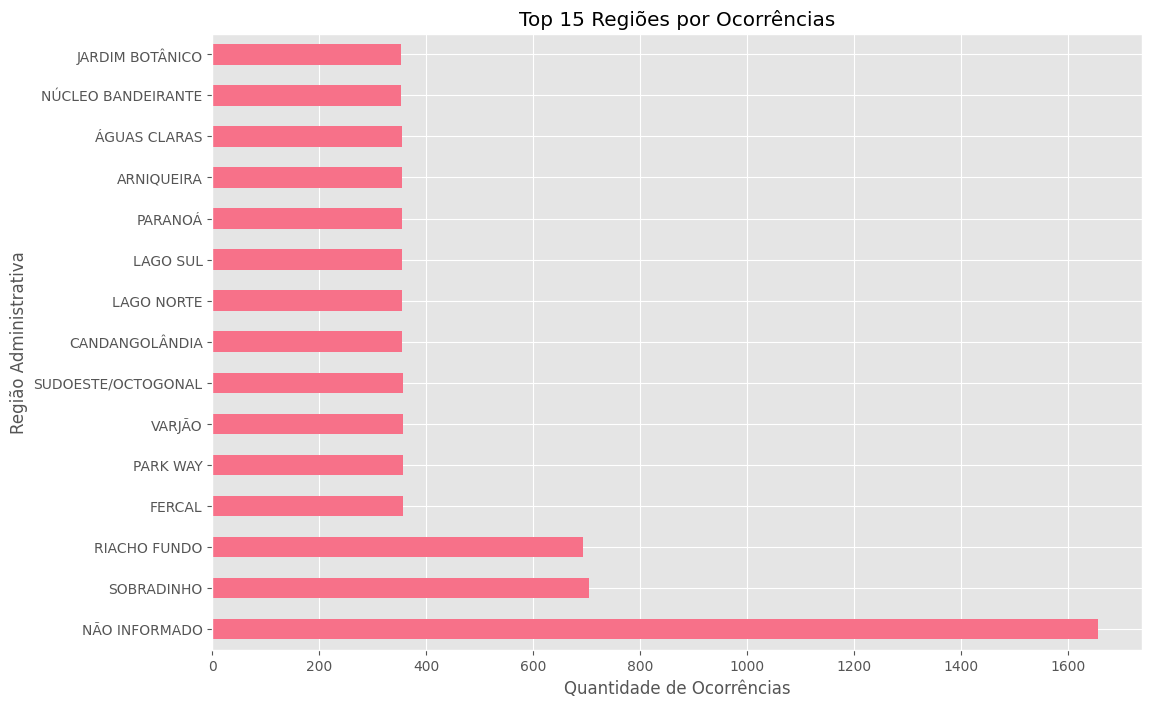

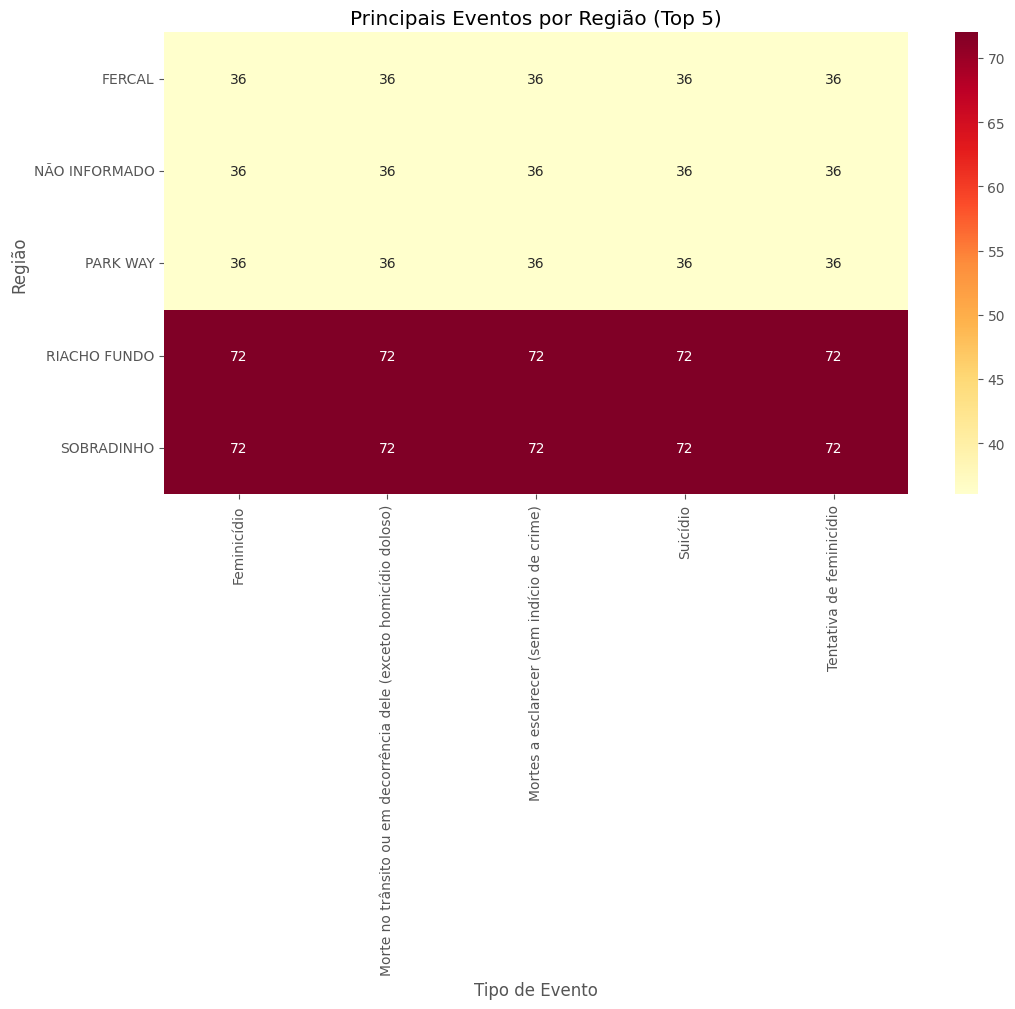

In [11]:
def analise_geografica(df):
    print("\nANÁLISE GEOGRÁFICA")
    
    # Top 15 regiões com mais ocorrências
    plt.figure(figsize=(12, 8))
    df['regiao'].value_counts().nlargest(15).plot(kind='barh')
    plt.title('Top 15 Regiões por Ocorrências')
    plt.xlabel('Quantidade de Ocorrências')
    plt.ylabel('Região Administrativa')
    plt.show()
    
    # Distribuição de tipos de crime por região (top 5 regiões)
    top_regioes = df['regiao'].value_counts().nlargest(5).index
    top_eventos = df['evento'].value_counts().nlargest(5).index
    
    pivot_data = df[
        (df['regiao'].isin(top_regioes)) & 
        (df['evento'].isin(top_eventos))
    ].pivot_table(
        index='regiao',
        columns='evento',
        values='uf',
        aggfunc='count',
        fill_value=0
    )
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_data, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Principais Eventos por Região (Top 5)')
    plt.xlabel('Tipo de Evento')
    plt.ylabel('Região')
    plt.show()

# Executa análise geográfica
analise_geografica(df)

Celula 6


ANÁLISE DE VÍTIMAS


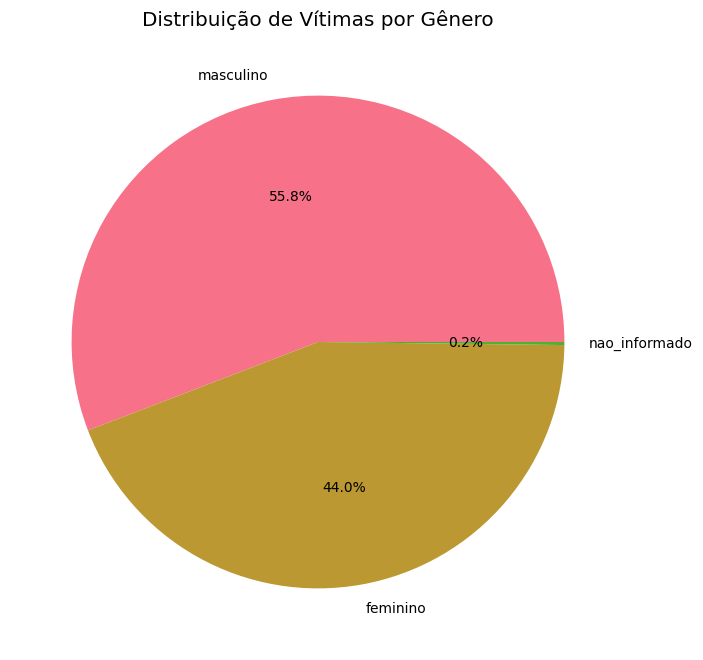

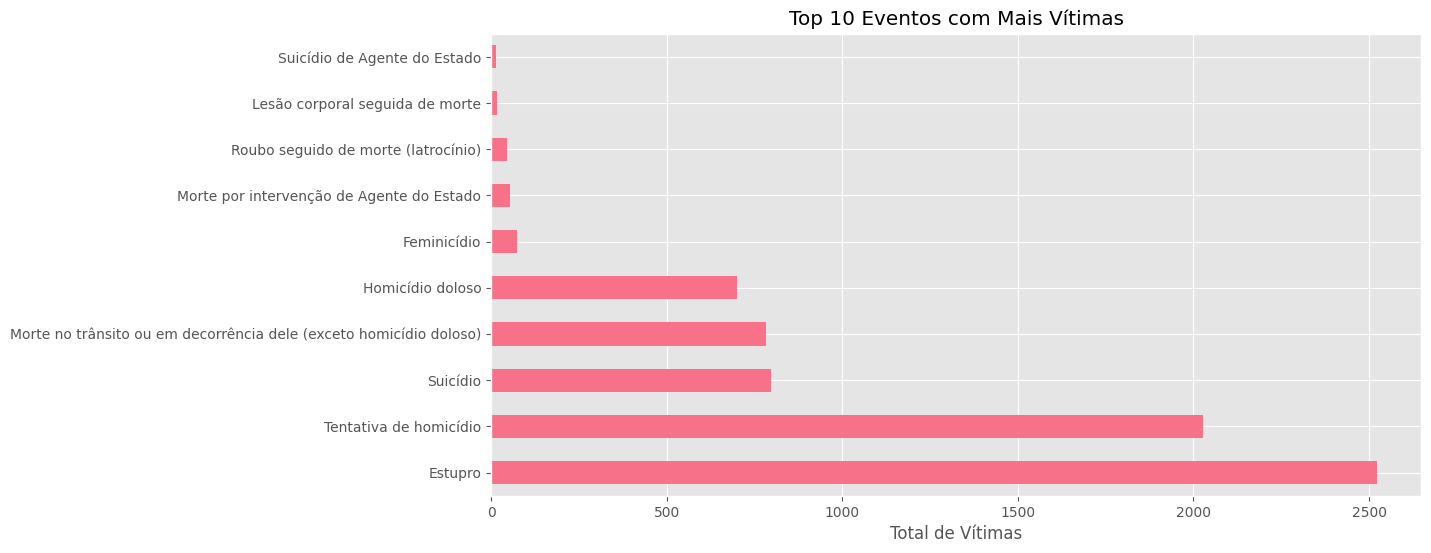

In [12]:
def analise_vitimas(df):
    print("\nANÁLISE DE VÍTIMAS")
    
    # Filtrar apenas registros com informação de vítimas
    vitimas_df = df[df['total_vitima'].notna()]
    
    # Distribuição por gênero
    genero_df = vitimas_df[['masculino', 'feminino', 'nao_informado']].sum()
    
    plt.figure(figsize=(8, 8))
    genero_df.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribuição de Vítimas por Gênero')
    plt.ylabel('')
    plt.show()
    
    # Top eventos com mais vítimas
    top_vitimas = vitimas_df.groupby('evento')['total_vitima'].sum().nlargest(10)
    
    plt.figure(figsize=(12, 6))
    top_vitimas.plot(kind='barh')
    plt.title('Top 10 Eventos com Mais Vítimas')
    plt.xlabel('Total de Vítimas')
    plt.ylabel('')
    plt.show()

# Executa análise de vítimas
analise_vitimas(df)

Análise de armas apreendidas


ANÁLISE DE ARMAS


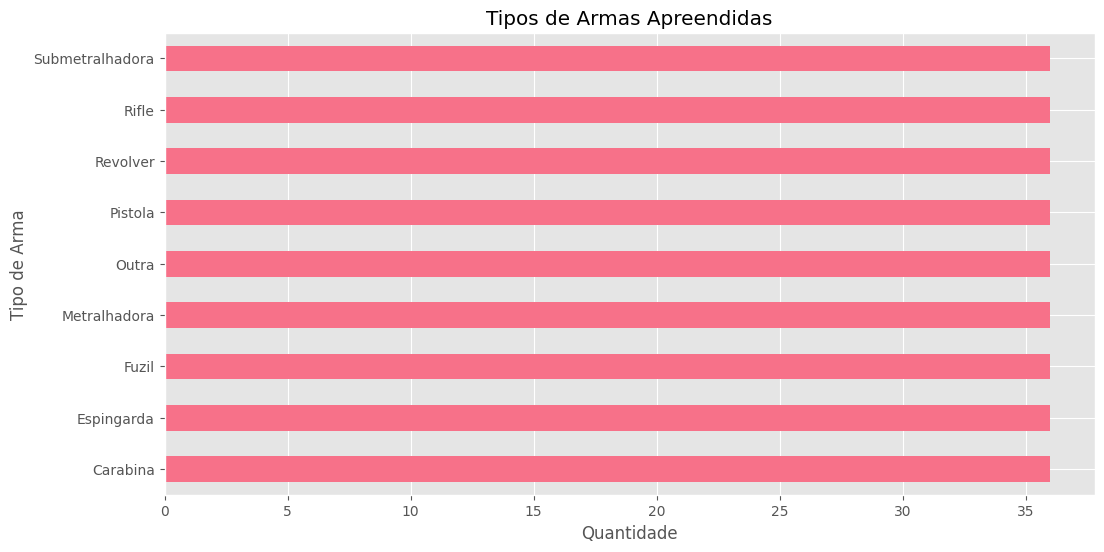

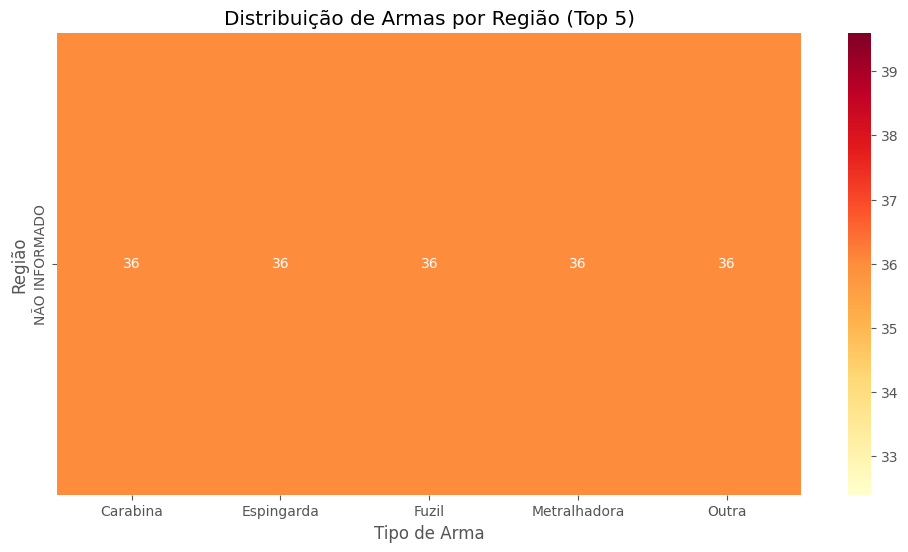

In [13]:
def analise_armas(df):
    
    print("\nANÁLISE DE ARMAS")
    
    # Filtrar apenas eventos de apreensão de armas
    armas_df = df[df['evento'] == 'Arma de Fogo Apreendida']
    
    if not armas_df.empty:
        # Tipos de armas mais apreendidas
        plt.figure(figsize=(12, 6))
        armas_df['arma'].value_counts().plot(kind='barh')
        plt.title('Tipos de Armas Apreendidas')
        plt.xlabel('Quantidade')
        plt.ylabel('Tipo de Arma')
        plt.show()
        
        # Armas por região
        top_armas = armas_df['arma'].value_counts().nlargest(5).index
        pivot_armas = armas_df[
            armas_df['arma'].isin(top_armas)
        ].pivot_table(
            index='regiao',
            columns='arma',
            values='evento',
            aggfunc='count',
            fill_value=0
        )
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot_armas, annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Distribuição de Armas por Região (Top 5)')
        plt.xlabel('Tipo de Arma')
        plt.ylabel('Região')
        plt.show()
    else:
        print("Nenhum registro de apreensão de armas encontrado")

# Executa análise de armas
analise_armas(df)

    Análise de apreensão de drogas



 ANÁLISE DE DROGAS


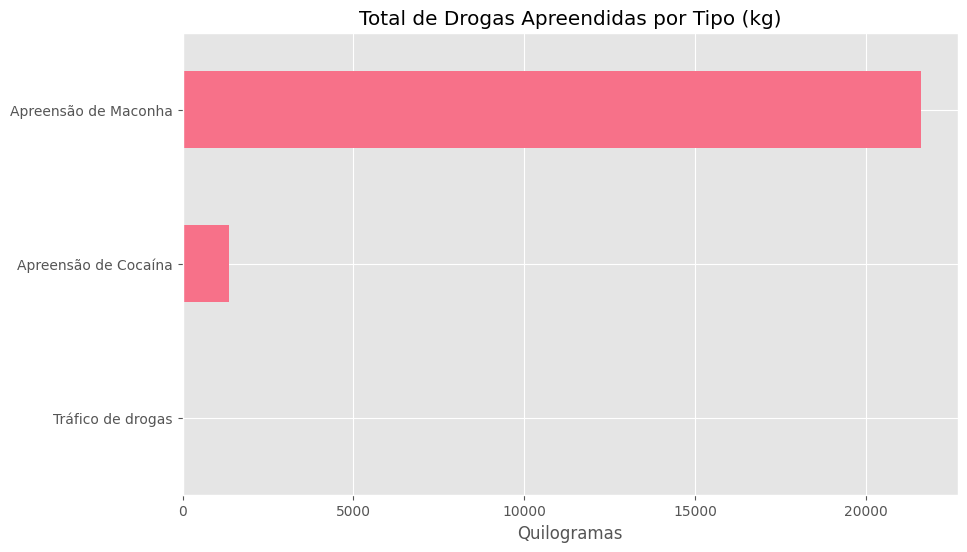

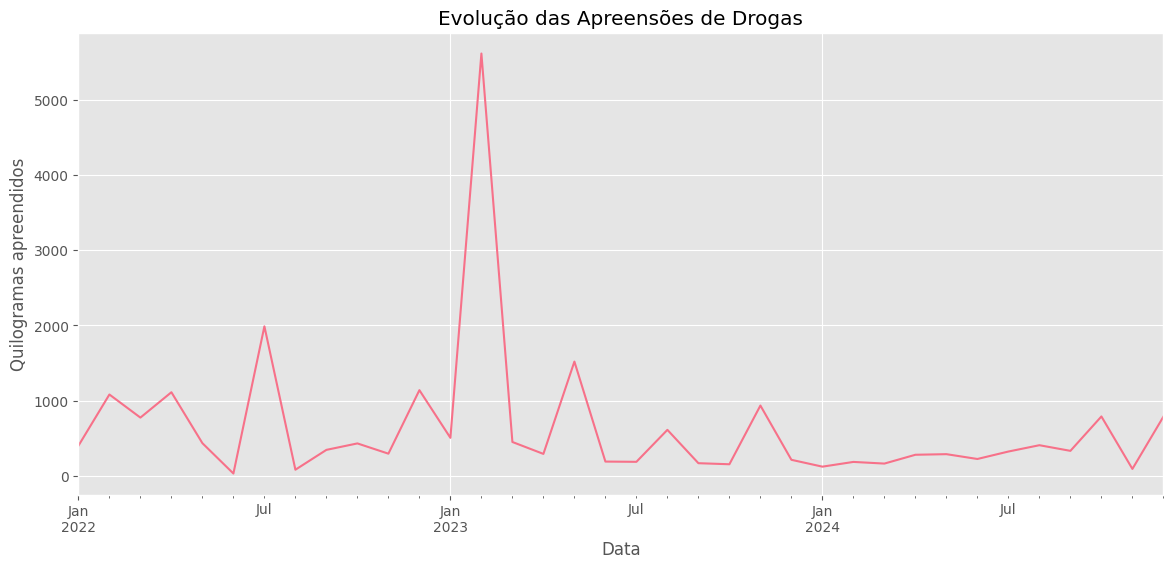

In [14]:
def analise_drogas(df):
    print("\n ANÁLISE DE DROGAS")
    
    # Filtrar eventos relacionados a drogas
    drogas_df = df[df['evento'].str.contains('droga|cocaína|maconha', case=False, na=False)]
    
    if not drogas_df.empty:
        # Total apreendido por tipo
        plt.figure(figsize=(10, 6))
        drogas_df.groupby('evento')['total_peso'].sum().sort_values().plot(kind='barh')
        plt.title('Total de Drogas Apreendidas por Tipo (kg)')
        plt.xlabel('Quilogramas')
        plt.ylabel('')
        plt.show()
        
        # Evolução temporal
        plt.figure(figsize=(14, 6))
        drogas_df.groupby('data')['total_peso'].sum().plot()
        plt.title('Evolução das Apreensões de Drogas')
        plt.ylabel('Quilogramas apreendidos')
        plt.xlabel('Data')
        plt.grid(True)
        plt.show()
    else:
        print("Nenhum registro de apreensão de drogas encontrado")

# Executa análise de drogas
analise_drogas(df)

    Análise por órgão responsável


ANÁLISE POR ÓRGÃO RESPONSÁVEL


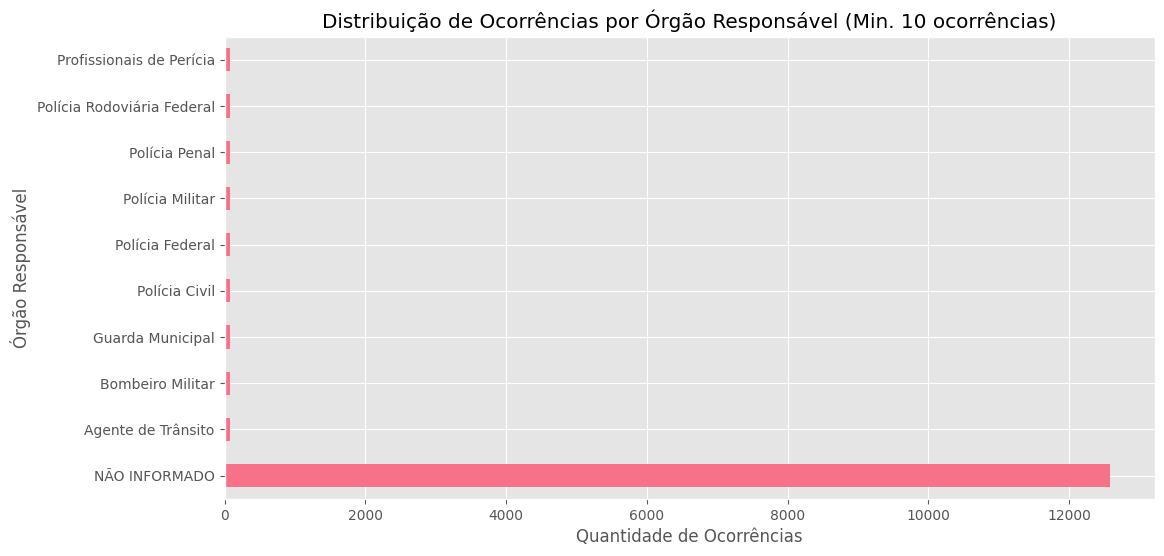

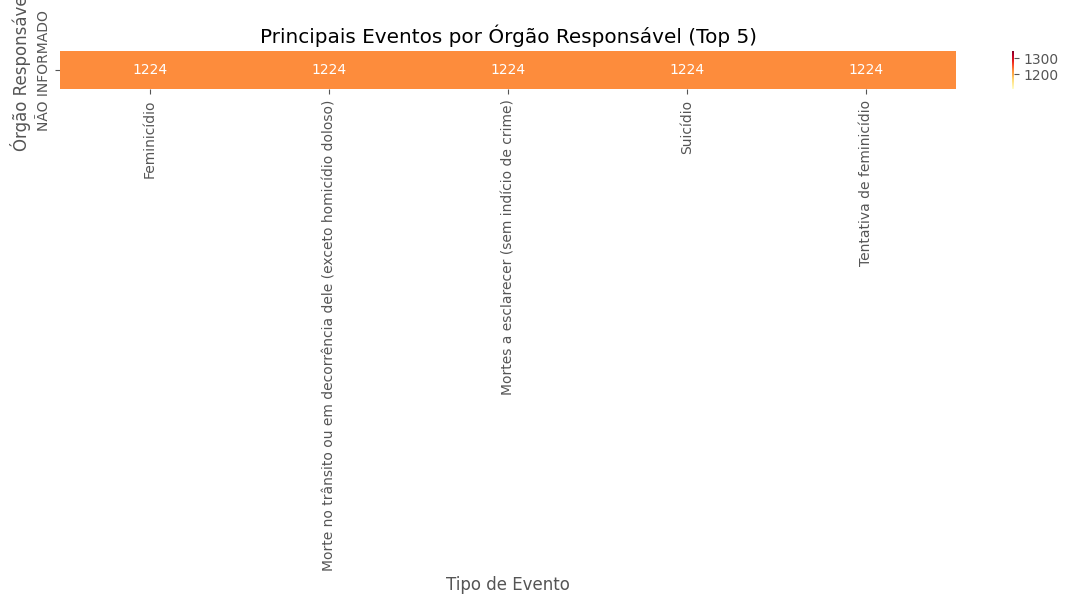

In [15]:
def analise_agentes(df):
    print("\nANÁLISE POR ÓRGÃO RESPONSÁVEL")
    
    # Criar uma cópia do DataFrame para análise
    agentes_df = df.copy()
    
    # Substituir valores None/NaN por 'NÃO INFORMADO'
    agentes_df['agente'] = agentes_df['agente'].fillna('NÃO INFORMADO')
    
    # 1. Distribuição geral de ocorrências por órgão
    plt.figure(figsize=(12, 6))
    contagem_agentes = agentes_df['agente'].value_counts()
    
    # Filtrar apenas órgãos com mais de X ocorrências para melhor visualização
    contagem_agentes[contagem_agentes > 10].plot(kind='barh')
    plt.title('Distribuição de Ocorrências por Órgão Responsável (Min. 10 ocorrências)')
    plt.xlabel('Quantidade de Ocorrências')
    plt.ylabel('Órgão Responsável')
    plt.show()
    
    # 2. Análise dos órgãos com mais ocorrências
    top_agentes = contagem_agentes.nlargest(5).index
    top_eventos = agentes_df['evento'].value_counts().nlargest(5).index
    
    # Criar tabela pivot somente se houver dados suficientes
    if len(top_agentes) > 0 and len(top_eventos) > 0:
        pivot_agentes = agentes_df[
            (agentes_df['agente'].isin(top_agentes)) & 
            (agentes_df['evento'].isin(top_eventos))
        ].pivot_table(
            index='agente',
            columns='evento',
            values='uf',
            aggfunc='count',
            fill_value=0
        )
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot_agentes, annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Principais Eventos por Órgão Responsável (Top 5)')
        plt.xlabel('Tipo de Evento')
        plt.ylabel('Órgão Responsável')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Dados insuficientes para análise detalhada por órgão responsável")

# Executa análise por agentes
analise_agentes(df)

In [16]:
# Fecha a conexão com o banco de dados
if engine:
    engine.dispose()
    print("✅ Conexão com o banco de dados encerrada")

✅ Conexão com o banco de dados encerrada
